In [1]:
import os
import pickle
from functools import partial

import numpy as np
import pyabc
from fitmulticell import model as morpheus_model
from fitmulticell.sumstat import SummaryStatistics
from matplotlib import pyplot as plt
from tarp import get_tarp_coverage
from tqdm import tqdm

from load_bayesflow_model import load_model, custom_loader
from plotting_routines import plot_compare_summary_stats, plot_trajectory, \
    plot_autocorrelation
from summary_stats import reduced_coordinates_to_sumstat, reduce_to_coordinates, \
    compute_mean_summary_stats

# get the job array id and number of processors
job_array_id = int(os.environ.get('SLURM_ARRAY_TASK_ID', 0))
n_procs = int(os.environ.get('SLURM_CPUS_PER_TASK', 1))
print(job_array_id)
on_cluster = False

0


/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
if on_cluster:
    gp = '/home/jarruda_hpc/CellMigration/synth_data_params_bayesflow'
else:
    gp = os.getcwd()

# defining the mapping of parameter inside the model xml file. the dictionary name is for 
# parameter name, and the value are the mapping values, to get the map value for parameter 
# check here: https://fitmulticell.readthedocs.io/en/latest/example/minimal.html#Inference-problem-definition

par_map = {
    'gradient_strength': './CellTypes/CellType/Constant[@symbol="gradient_strength"]',
    'move.strength': './CellTypes/CellType/Constant[@symbol="move.strength"]',
    'move.duration.mean': './CellTypes/CellType/Constant[@symbol="move.duration.mean"]',
    'cell_nodes_real': './Global/Constant[@symbol="cell_nodes_real"]',
}

model_path = gp + "/cell_movement_v24.xml"  # time step is 30sec, move.dir completely normalized, init move.dir rand in all directions
# defining the summary statistics function
max_sequence_length = 120
min_sequence_length = 0
only_longest_traj_per_cell = True  # mainly to keep the data batchable
sumstat = SummaryStatistics(sum_stat_calculator=partial(reduce_to_coordinates,
                                                        minimal_length=min_sequence_length,
                                                        maximal_length=max_sequence_length,
                                                        only_longest_traj_per_cell=only_longest_traj_per_cell))                    

if on_cluster:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        executable="ulimit -s unlimited; /home/jarruda_hpc/CellMigration/morpheus-2.3.7",
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

    # todo: remember also change tiff path in model.xml!
else:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)


# parameter values used to generate the synthetic data
obs_pars = {
    'gradient_strength': 100.,  # strength of the gradient of chemotaxis (energy potential)
    'move.strength': 10.,  # strength of directed motion (energy potential)
    'move.duration.mean': 0.1,  # mean of exponential distribution (seconds)
    'cell_nodes_real': 50.,  # volume of the cell  (\mu m^2)
}

obs_pars_log = {key: np.log10(val) for key, val in obs_pars.items()}
limits = {'gradient_strength': (1, 10000), #(10 ** 4, 10 ** 8),
          'move.strength': (1, 100),
          'move.duration.mean': (1e-4, 30), #(math.log10((10 ** -2) * 30), math.log10((10 ** 4))), # smallest time step in simulation 5
          'cell_nodes_real': (1, 300)}
limits_log = {key: (np.log10(val[0]), np.log10(val[1])) for key, val in limits.items()}


prior = pyabc.Distribution(**{key: pyabc.RV("uniform", loc=lb, scale=ub-lb)
                              for key, (lb, ub) in limits_log.items()})
param_names = list(obs_pars.keys())
log_param_names = [f'log_{p}' for p in param_names]
print(obs_pars)

{'gradient_strength': 100.0, 'move.strength': 10.0, 'move.duration.mean': 0.1, 'cell_nodes_real': 50.0}


In [3]:
import tensorflow as tf
import bayesflow as bf
from bayesflow.simulation import GenerativeModel, Prior, Simulator


def prior_fun(batch_size: int) -> np.ndarray:
    samples = []
    for _ in range(batch_size):
        samples.append(list(prior.rvs().values()))
    return np.array(samples)


def generate_population_data(param_batch: np.ndarray, cells_in_population: int, max_length: int) -> np.ndarray:
    """
    Generate population data
    :param param_batch:  batch of parameters
    :param cells_in_population:  number of cells in a population (50)
    :param max_length:  maximum length of the sequence
    :return:
    """
    data_batch = []
    for params in param_batch:
        params_dict = {key: p for key, p in zip(obs_pars.keys(), params)}
        sim = model.sample(params_dict)
        data_batch.append(sim)  # generates a cell population in one experiment

    data_batch_transformed = np.ones((param_batch.shape[0], cells_in_population, max_length, 2)) * np.nan
    # each cell is of different length, each with x and y coordinates, make a tensor out of it
    n_cells_not_visible = 0
    for p_id, population_sim in enumerate(data_batch):
        if len(population_sim) == 0:
            # no cells were visible in the simulation
            n_cells_not_visible += 1
            continue
        for c_id, cell_sim in enumerate(population_sim):
            # pre-pad the data with zeros, but first write zeros as nans to compute the mean and std
            data_batch_transformed[p_id, c_id, -len(cell_sim['x']):, 0] = cell_sim['x']
            data_batch_transformed[p_id, c_id, -len(cell_sim['y']):, 1] = cell_sim['y']

    if n_cells_not_visible > 0:
        print(f'Simulation with no cells visible: {n_cells_not_visible}/{len(data_batch)}')
    return data_batch_transformed

In [4]:
presimulate = False
presimulation_path = 'presimulations'
n_val_data = 100
cells_in_population = 50
n_params = len(obs_pars)
batch_size = 32
iterations_per_epoch = 100
# 1000 batches to be generated, 10 epochs until the batch is used again
epochs = 500

# check if gpu is available
print('gpu:', tf.config.list_physical_devices('GPU'))

bayesflow_prior = Prior(batch_prior_fun=prior_fun, param_names=param_names)
bayes_simulator = Simulator(batch_simulator_fun=partial(generate_population_data,
                                                        cells_in_population=cells_in_population,
                                                        max_length=max_sequence_length))
generative_model = GenerativeModel(prior=bayesflow_prior, simulator=bayes_simulator,
                                   skip_test=True,  # once is enough, simulation takes time
                                   name="Normalizing Flow Generative Model")

gpu: []


In [5]:
if presimulate:
    print('presimulating')
    from time import sleep
    sleep(job_array_id)

    # we create on batch per job and save it in a folder
    epoch_id = job_array_id // iterations_per_epoch
    generative_model.presimulate_and_save(
        batch_size=batch_size,
        folder_path=presimulation_path+f'/epoch_{epoch_id}',
        iterations_per_epoch=1,
        epochs=1,
        extend_from=job_array_id,
        disable_user_input=True
    )
    print('Done!')

In [6]:
if os.path.exists(os.path.join(gp, 'validation_data.pickle')):
    with open(os.path.join(gp, 'validation_data.pickle'), 'rb') as f:
        valid_data = pickle.load(f)
else:
    print('Generating validation data')
    valid_data = generative_model(n_val_data)
    # save the data
    with open(os.path.join(gp, 'validation_data.pickle'), 'wb') as f:
        pickle.dump(valid_data, f)

x_mean = np.nanmean(valid_data['sim_data'], axis=(0, 1, 2))
x_std = np.nanstd(valid_data['sim_data'], axis=(0, 1, 2))
p_mean = np.mean(valid_data['prior_draws'], axis=0)
p_std = np.std(valid_data['prior_draws'], axis=0)
print('Mean and std of data:', x_mean, x_std)
print('Mean and std of parameters:', p_mean, p_std)


# compute the mean of the summary statistics
summary_stats_list_ = [reduced_coordinates_to_sumstat(t) for t in valid_data['sim_data']]
(_, ad_averg, _, MSD_averg, _, TA_averg, _, VEL_averg, _, WT_averg) = compute_mean_summary_stats(summary_stats_list_, remove_nan=False)
direct_conditions_ = np.stack([ad_averg, MSD_averg, TA_averg, VEL_averg, WT_averg]).T
# replace inf with -1
direct_conditions_[np.isinf(direct_conditions_)] = np.nan
        
summary_valid_max = np.nanmax(direct_conditions_, axis=0)
summary_valid_min = np.nanmin(direct_conditions_, axis=0)

Mean and std of data: [ 584.8564567  1218.30836285] [48.56665046 59.88427128]
Mean and std of parameters: [ 1.95494199  0.99490352 -1.43414929  1.15144457] [1.13024234 0.57772408 1.38909074 0.76196229]


In [7]:
job_array_id = 8  # best: 5
trainer, map_idx_sim = load_model(
    model_id=job_array_id, 
    x_mean=x_mean,
    x_std=x_std,
    p_mean=p_mean,
    p_std=p_std,
    summary_valid_max=summary_valid_max,
    summary_valid_min=summary_valid_min,
    generative_model=generative_model
)

Loading ensemble model


In [9]:
# check if the model is already trained
if not os.path.exists(trainer.checkpoint_path):
    trainer._setup_optimizer(
        optimizer=None,
        epochs=epochs,
        iterations_per_epoch=iterations_per_epoch
    )

    history = trainer.train_from_presimulation(
        presimulation_path=presimulation_path,
        optimizer=trainer.optimizer,
        max_epochs=epochs,
        early_stopping=True,
        early_stopping_args={'patience': 17 - 2},
        custom_loader=custom_loader,
        validation_sims=valid_data
    )
    print('Training done!')
else:
    history = trainer.loss_history.get_plottable()

Final validation loss: 0.3090999573469162


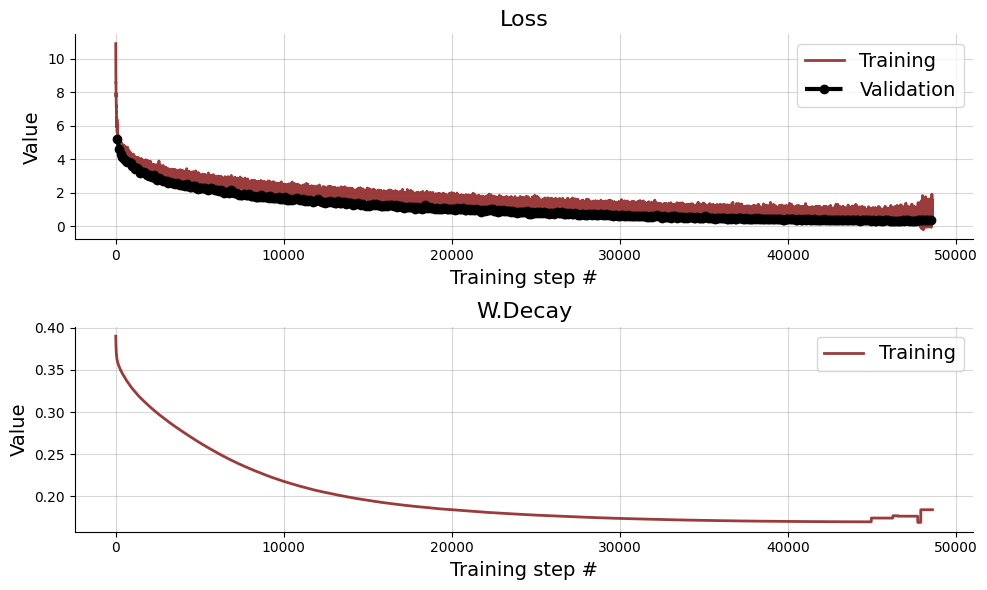

In [10]:
bf.diagnostics.plot_losses(history['train_losses'], history['val_losses'], fig_size=(10, 6))
print('Final validation loss:', np.min(history['val_losses']))

# Diagnostic plots

In [11]:
valid_data_config = trainer.configurator(valid_data)

In [12]:
posterior_samples = trainer.amortizer.sample(valid_data_config, n_samples=100)
posterior_samples = posterior_samples * p_std + p_mean
if isinstance(valid_data_config, list):  # for ensemble
    prior_draws = valid_data_config[0]["parameters"] * p_std + p_mean
else:
    prior_draws = valid_data_config["parameters"] * p_std + p_mean

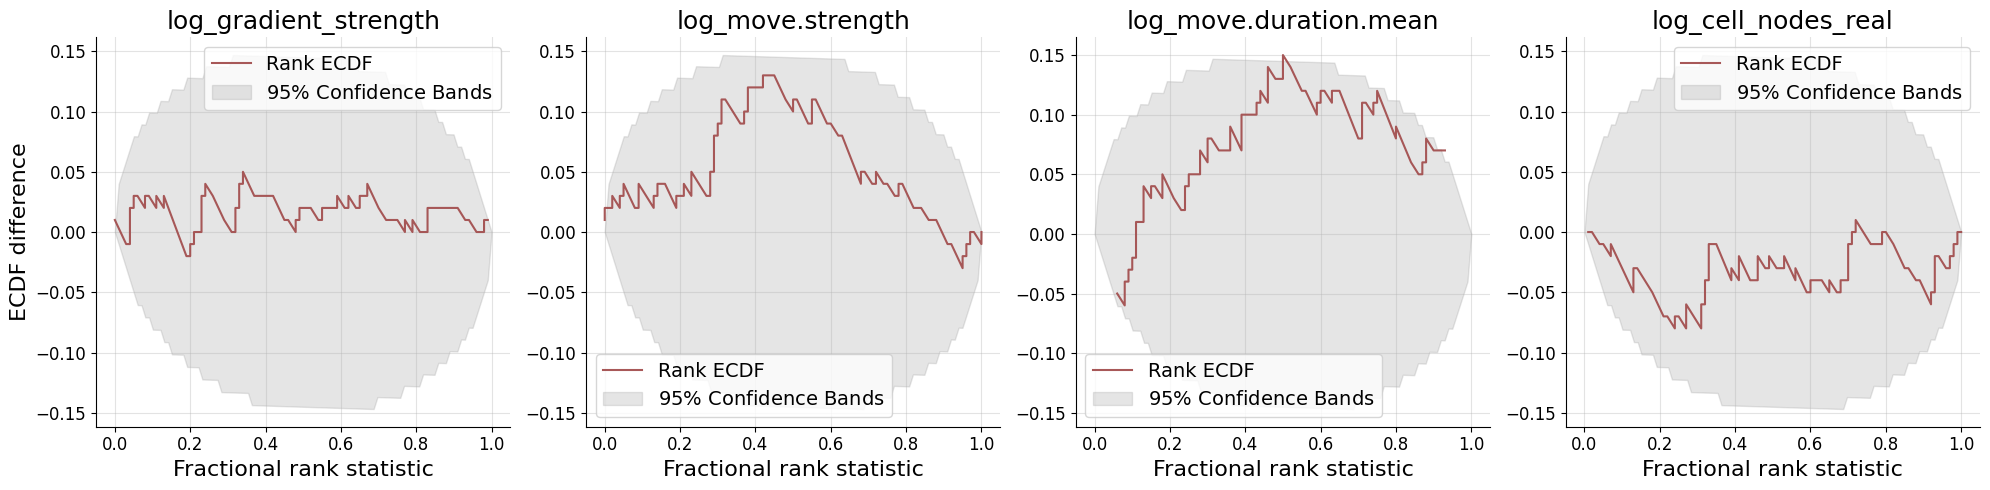

In [13]:
bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_draws, difference=True, param_names=log_param_names)
plt.savefig(f'{trainer.checkpoint_path}/sbc_ecdf.png')

In [20]:
posterior_samples = trainer.amortizer.sample(valid_data_config, n_samples=1000)
posterior_samples = posterior_samples * p_std + p_mean

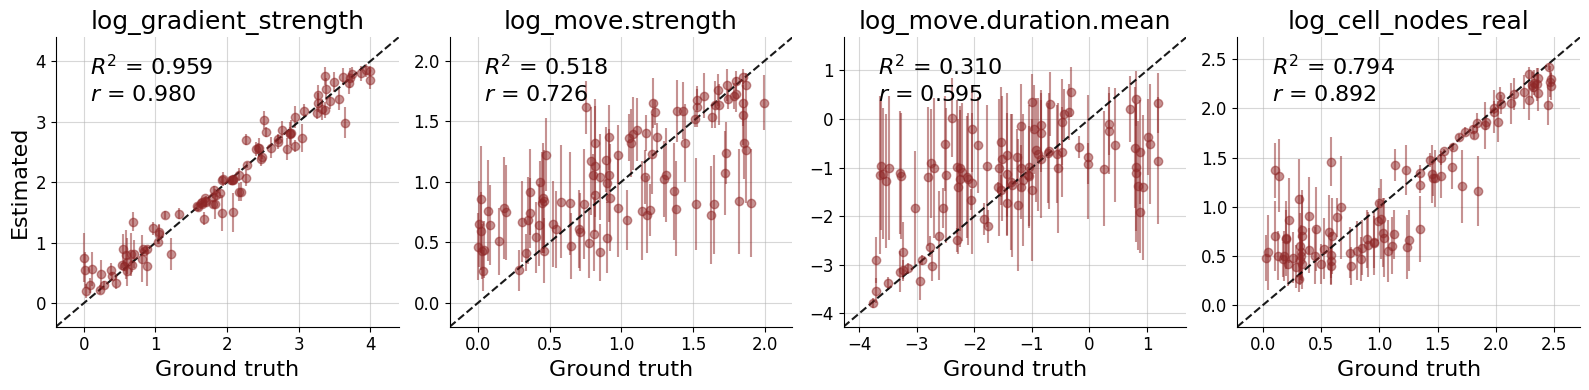

In [21]:
bf.diagnostics.plot_recovery(posterior_samples, prior_draws, param_names=log_param_names)
plt.savefig(f'{trainer.checkpoint_path}/recovery.png')

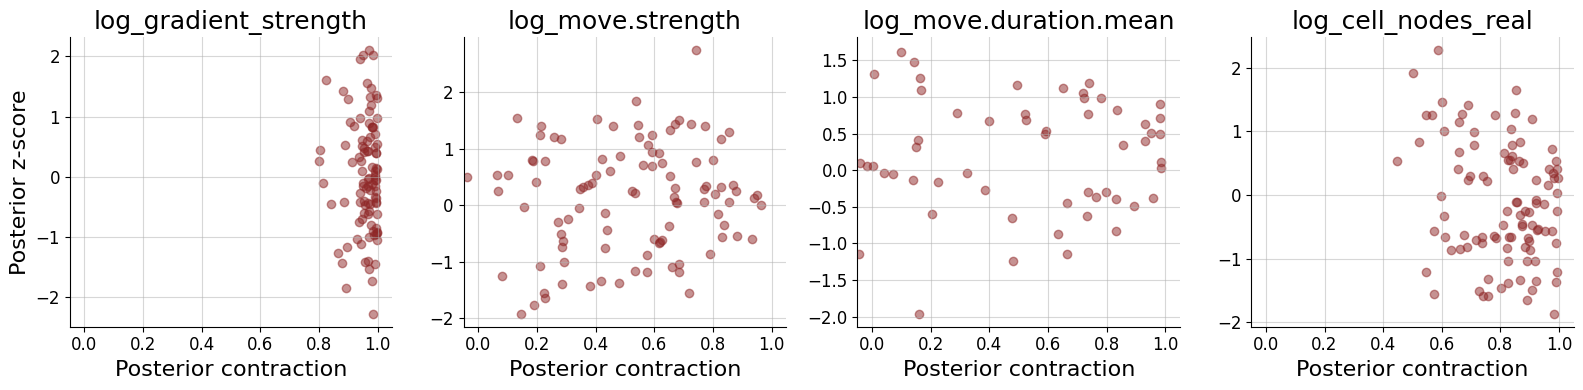

In [22]:
bf.diagnostics.plot_z_score_contraction(posterior_samples, prior_draws, param_names=log_param_names);

In [23]:
posterior_samples_reshaped = posterior_samples.reshape(posterior_samples.shape[1],
                                                       posterior_samples.shape[0], posterior_samples.shape[2])

In [24]:
ecp_bootstrap, alpha = get_tarp_coverage(posterior_samples_reshaped, prior_draws, references='random',
                                         metric='euclidean', norm=True, bootstrap=True)

100%|██████████| 100/100 [00:00<00:00, 276.26it/s]


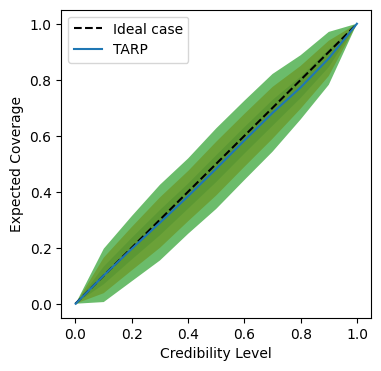

In [25]:
k_sigma = [1, 2, 3]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot([0, 1], [0, 1], ls='--', color='k', label="Ideal case")
ax.plot(alpha, ecp_bootstrap.mean(axis=0), label='TARP')
for k in k_sigma:
    ax.fill_between(alpha, 
                    ecp_bootstrap.mean(axis=0) - k * ecp_bootstrap.std(axis=0), 
                    ecp_bootstrap.mean(axis=0) + k * ecp_bootstrap.std(axis=0), 
                    alpha = 0.7)
ax.legend()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")
plt.show()

# Test on synthetic data

In [26]:
# simulate test data
test_params = np.array(list(obs_pars_log.values()))
if not os.path.exists(os.path.join(gp, 'test_sim.npy')):
    test_sim_full = bayes_simulator(test_params[np.newaxis])
    test_sim = test_sim_full['sim_data']
    np.save(os.path.join(gp, 'test_sim.npy'), test_sim)
else:
    test_sim = np.load(os.path.join(gp, 'test_sim.npy'))
    test_sim_full = {'sim_data': test_sim}
test_sim.shape

(1, 50, 120, 2)

In [28]:
test_posterior_samples = trainer.amortizer.sample(trainer.configurator(test_sim_full), n_samples=100)
test_posterior_samples = test_posterior_samples * p_std + p_mean
test_posterior_samples_median = np.median(test_posterior_samples, axis=0)
# compute the log posterior of the test data
input_dict = {
    'sim_data': np.repeat(test_sim, repeats=100, axis=0),
    'parameters': test_posterior_samples
}
#log_prob = trainer.amortizer.log_posterior(trainer.configurator(input_dict))
    
# get the MAP
#map_idx = np.argmax(log_prob)

# save posterior samples to load in abc results
#np.save(f'{trainer.checkpoint_path}/posterior_samples_synthetic.npy', test_posterior_samples)

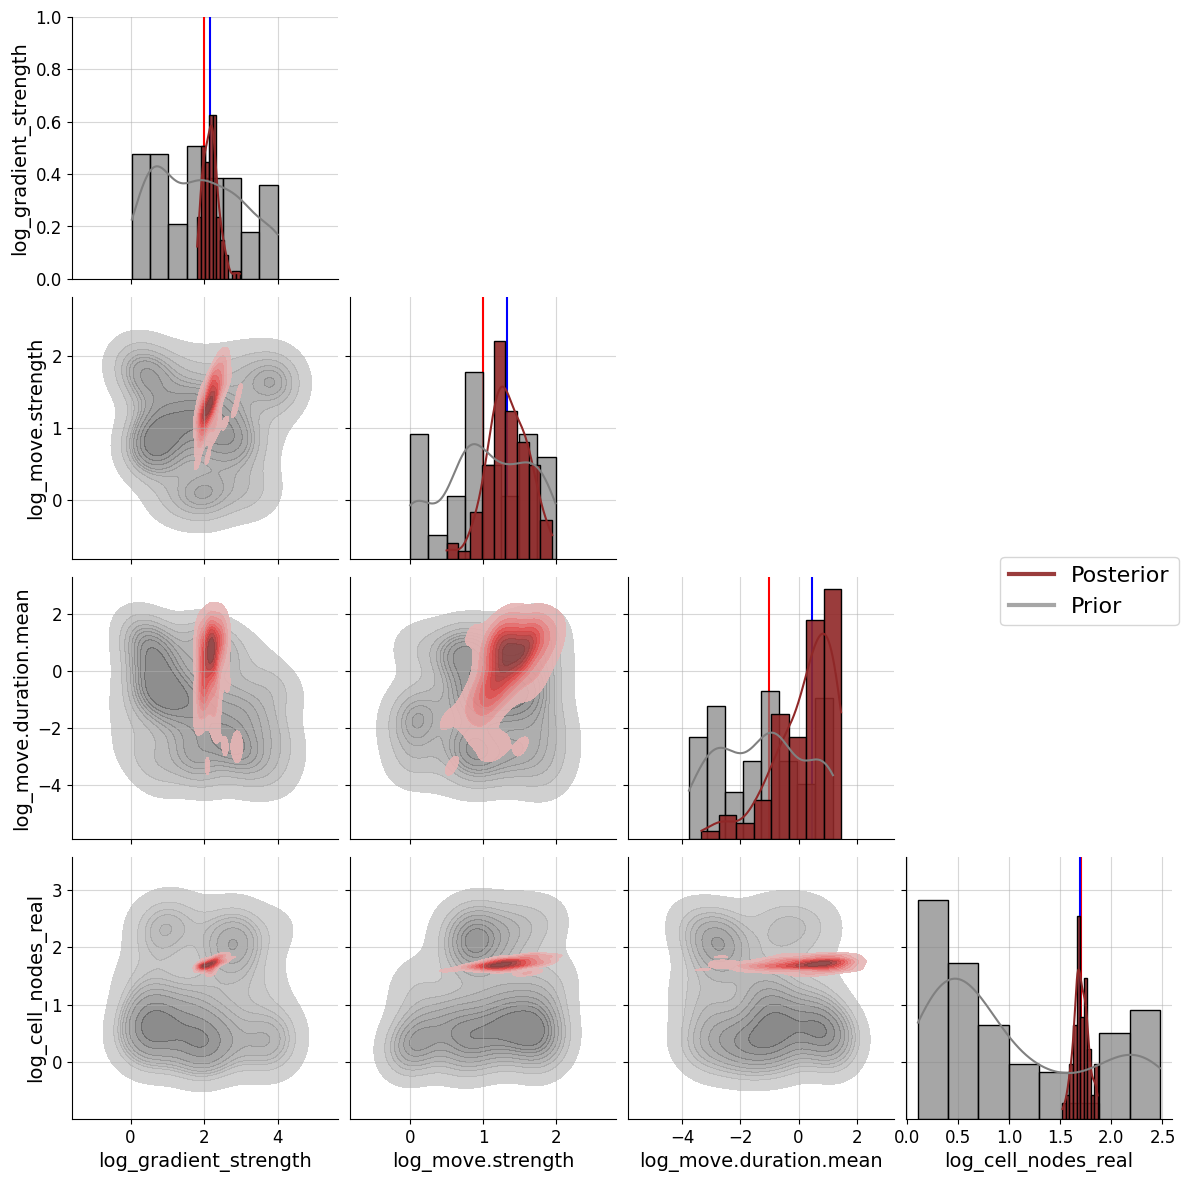

In [29]:
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=test_posterior_samples,
                                       prior_draws=prior_draws[:test_posterior_samples.shape[0]],
                                       param_names=log_param_names)
# from figure get axis
ax = fig.get_axes()
for i, a in enumerate(ax):
    # plot only on the diagonal
    if i == i // len(log_param_names) * (len(log_param_names)+1):
        a.axvline(test_params[i // len(log_param_names)], color='r', label='True parameter')
for i, a in enumerate(ax):
    # plot only on the diagonal
    if i == i // len(log_param_names) * (len(log_param_names)+1):
        a.axvline(test_posterior_samples_median[i // len(log_param_names)], color='b', label='Median parameter')
#plt.savefig(f'{trainer.checkpoint_path}/posterior_vs_prior.png')
plt.show()

In [30]:
# get posterior samples and simulate
if not os.path.exists(trainer.checkpoint_path+'/posterior_sim.npy'):
    # simulate the data
    posterior_sim = bayes_simulator(test_posterior_samples)['sim_data']
    np.save(trainer.checkpoint_path+'/posterior_sim.npy', posterior_sim)
    
    print('map_sim', map_idx, log_prob[map_idx], test_posterior_samples[map_idx])
    map_idx_sim = map_idx
else:
    posterior_sim = np.load(trainer.checkpoint_path+'/posterior_sim.npy')

# reorder the posterior samples
posterior_sim = np.delete(posterior_sim, map_idx_sim, axis=0)
posterior_sim = np.insert(posterior_sim, 0, posterior_sim[map_idx_sim][np.newaxis], axis=0)

KeyboardInterrupt: 

In [ ]:
# plot the summary statistics
plot_compare_summary_stats(test_sim, posterior_sim, path=f'{trainer.checkpoint_path}/Summary Stats')

In [ ]:
# plot the trajectories
plot_trajectory(test_sim[0], posterior_sim[0], path=f'{trainer.checkpoint_path}/Simulations', show_umap=True)
plot_autocorrelation(test_sim[0], posterior_sim[0], path=f'{trainer.checkpoint_path}/Autocorrelation')

In [ ]:
if trainer.amortizer.summary_loss is not None:
    test_data_config = trainer.configurator(test_sim_full)
    
    MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
        observed_data=test_data_config, 
        reference_data=valid_data_config,  # if not provided, will use the generative model
        num_null_samples=500,
        bootstrap=True  # if True, use the reference data as null samples
    )
    fig = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)
    fig.savefig(f'{trainer.checkpoint_path}/Synthetic MMD.png', bbox_inches='tight')
    plt.show()

# Real Data

In [31]:
from load_data import load_real_data

wasserstein_distance_dict = {0: np.nan, 1: np.nan}
samples_dict = {0: np.nan, 1: np.nan}
prior_draws = prior_fun(1000)

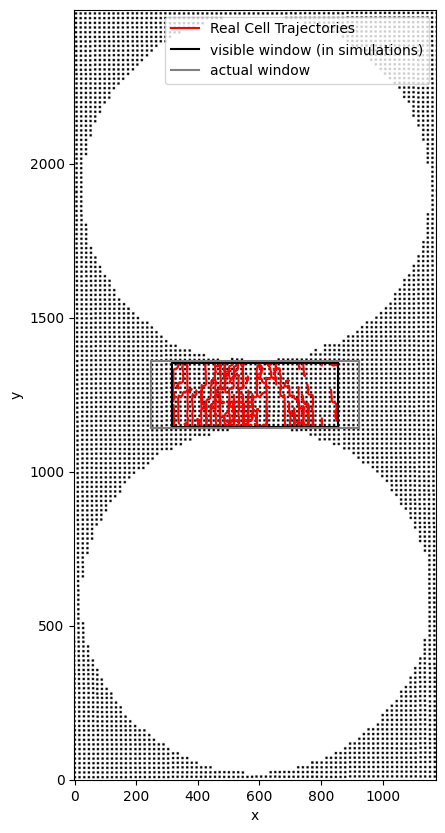

(50, 120, 2)


In [32]:
real_data_id = [0, 1][1]
real_data, real_data_full = load_real_data(data_id=real_data_id, 
                                           max_sequence_length=max_sequence_length, 
                                           cells_in_population=cells_in_population,
                                           plot_data=True)
real_data = np.array([real_data[start:start+cells_in_population] for start in range(0, len(real_data), cells_in_population)])[0]
print(real_data.shape)

Zelldichte macht was aus

Wo wollen Zellen hin? welche parameter beeinflussen das ganze? Zelldichte?

1,5mm

1 (nicht so gut, extrema)
739.79x279.74  microns
20231x768 pixel


2 (wesentlich mehr der Wahrheit)
882.94x287.03 microns
2424x788 pixel


In [34]:
# batch the real data
batches = [real_data[i * cells_in_population:(i + 1) * cells_in_population] 
           for i in range(len(real_data) // cells_in_population)]
real_posterior_samples_full = []
n_samples = prior_draws.shape[0]

for b in tqdm(batches):
    real_posterior_samples = trainer.amortizer.sample(trainer.configurator({'sim_data': b[np.newaxis]}), 
                                          n_samples=n_samples)
    real_posterior_samples = real_posterior_samples * p_std + p_mean
    real_posterior_samples_full.append(real_posterior_samples)
    
    np.save(f'{trainer.checkpoint_path}/posterior_samples_real.npy', real_posterior_samples)
    
real_posterior_samples = np.concatenate(real_posterior_samples_full)
samples_dict[real_data_id] = real_posterior_samples

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


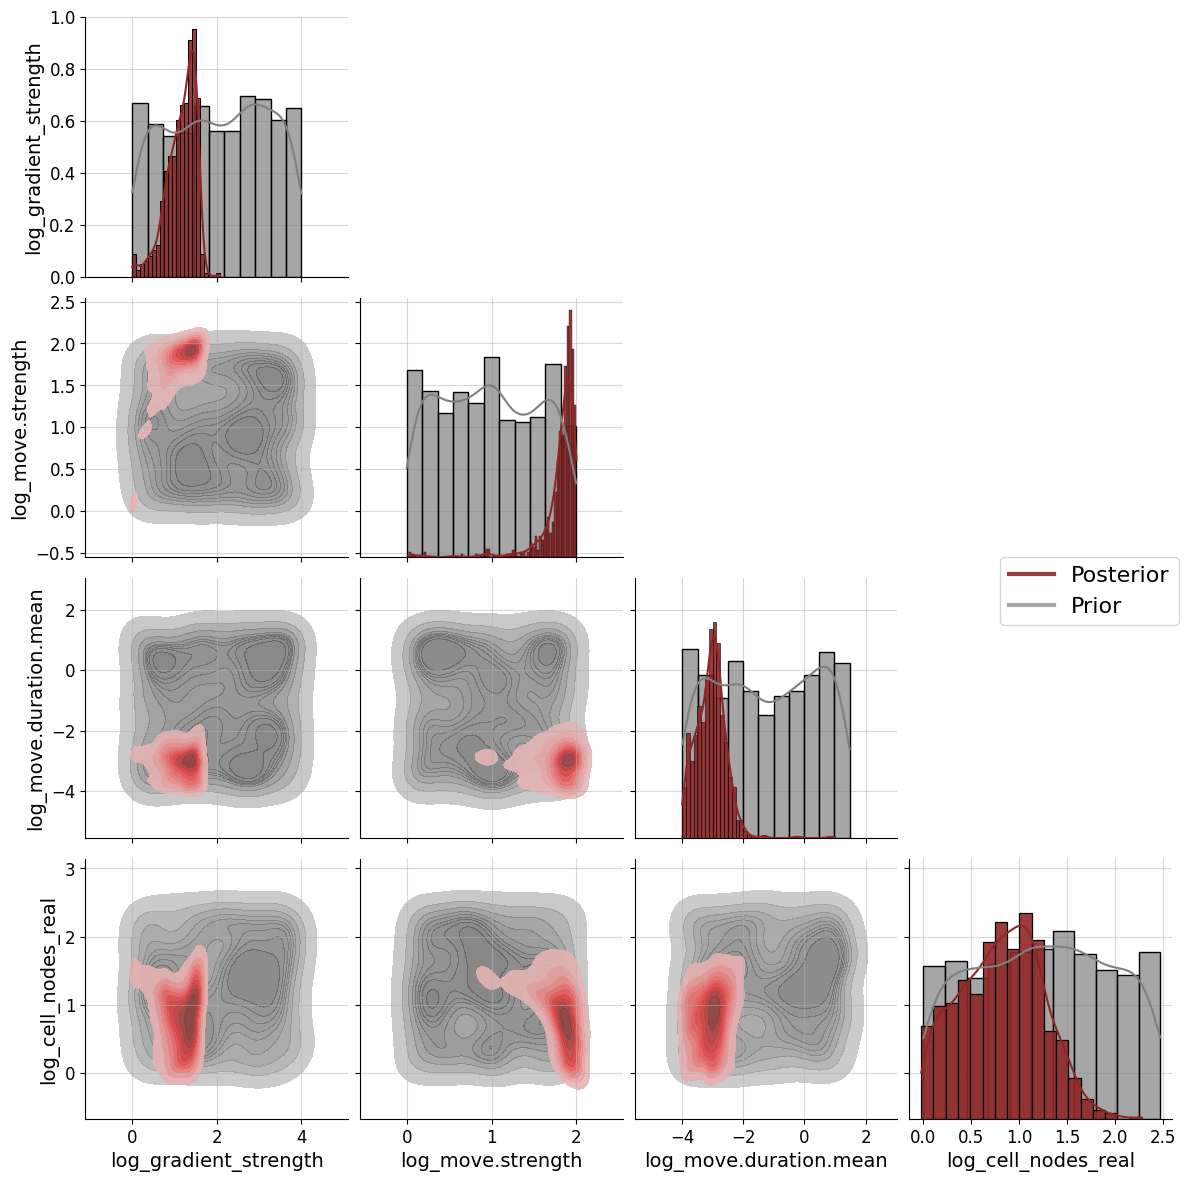

In [35]:
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=real_posterior_samples,
                                       prior_draws=prior_draws[:real_posterior_samples.shape[0]],
                                       param_names=log_param_names)
plt.savefig(f'{trainer.checkpoint_path}/Real_{real_data_id} posterior_vs_prior {len(batches)}.png')
plt.show()

In [36]:
posterior_median = np.median(real_posterior_samples, axis=0)

In [37]:
# get posterior samples and simulate
if not os.path.exists(f'{trainer.checkpoint_path}/posterior_sim_real_{real_data_id}.npy'):
    # simulate the data
    sim_list = []
    for i in tqdm(range(10)):
        if i == 0:
            posterior_sim = bayes_simulator(posterior_median[np.newaxis])['sim_data'][0]
        else:
            posterior_sim = bayes_simulator(real_posterior_samples[i][np.newaxis])['sim_data'][0]
        sim_list.append(posterior_sim[np.newaxis])
    posterior_sim_real = np.concatenate(sim_list)
    np.save(f'{trainer.checkpoint_path}/posterior_sim_real_{real_data_id}.npy', posterior_sim_real)
else:
    posterior_sim_real = np.load(f'{trainer.checkpoint_path}/posterior_sim_real_{real_data_id}.npy')

100%|██████████| 10/10 [05:19<00:00, 31.96s/it]


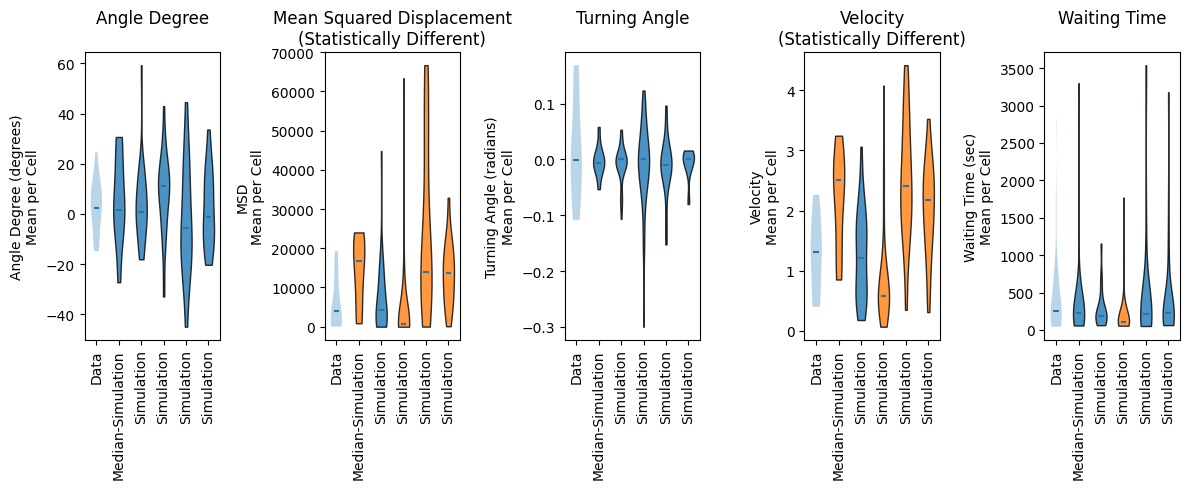

Wasserstein distance: 8751.717273170498
Wasserstein distance both datasets: nan


In [38]:
wasserstein_distance_dict[real_data_id] = plot_compare_summary_stats([real_data], posterior_sim_real, 
                                                                     path=f'{trainer.checkpoint_path}/Real_{real_data_id} vs Simulations {len(batches)}')
print(f"Wasserstein distance both datasets: {np.sum(list(wasserstein_distance_dict.values()))}")

In [ ]:
plot_trajectory(real_data, posterior_sim_real[0],
                path=f'{trainer.checkpoint_path}/Real_{real_data_id} Simulations {len(batches)}', 
                label_true='Real Trajectories', two_plots=True, show_image=False, show_umap=True)
plot_autocorrelation(real_data, posterior_sim_real[0], path=f'{trainer.checkpoint_path}/Real_{real_data_id} Autocorrelation {len(batches)}')

In [ ]:
if trainer.amortizer.summary_loss is not None:
    from matplotlib.cm import viridis
    real_data_config = trainer.configurator({'sim_data': batches})
    summary_statistics = trainer.amortizer.summary_net(valid_data_config['summary_conditions'])
    summary_statistics_obs = trainer.amortizer.summary_net(real_data_config['summary_conditions'])
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    colors = viridis(np.linspace(0.1, 0.9, 2))
    ax.scatter(
        summary_statistics_obs[:, 0], summary_statistics_obs[:, 1], color=colors[0], label=r"Observed: $h_{\psi}(x_{obs})$"
    )
    ax.scatter(summary_statistics[:, 0], summary_statistics[:, 1], color=colors[1], label=r"Well-specified: $h_{\psi}(x)$")
    ax.legend()
    ax.grid(alpha=0.2)
    plt.gca().set_aspect("equal")
    
    fig.savefig(f'{trainer.checkpoint_path}/Real_{real_data_id} Summary Latent Space.png',
                bbox_inches='tight')
    
    MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
        observed_data=real_data_config, 
        reference_data=valid_data_config,  # if not provided, will use the generative model
        num_null_samples=500,
        bootstrap=True  # if True, use the reference data as null samples
    )
    fig = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)
    fig.savefig(f'{trainer.checkpoint_path}/Real_{real_data_id} MMD.png',
                bbox_inches='tight')
    plt.show()

In [ ]:
if not np.isnan(samples_dict[0]).all() and not np.isnan(samples_dict[1]).all():
    fig = bf.diagnostics.plot_posterior_2d(posterior_draws=samples_dict[0],
                                           prior_draws=samples_dict[1],
                                           post_alpha=0.7,
                                           #post_color='red',
                                           prior_alpha=0.9, # other posterior samples
                                           prior_color='blue',
                                           param_names=log_param_names)
    plt.savefig(f'{trainer.checkpoint_path}/Real posterior_vs_posterior.png')
    plt.show()